### File Explanation

**trainRNN_StaticModel_learningRate.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', create a "Static Network" and train the network with respect to a range of learning rates

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer static model (function: **LSTM_Model** in **trainRNN_network_utils.py**)
<br> 5) Create a single normalised output by using the last outputs of static models of gene A and gene B (function: **batch_normalised_sum** in **trainRNN_network_utils.py**)
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_inputs** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsStaticLearningRate_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 2) **testLosses**: Test losses, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 3) **F1_scores**: F1_scores, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of ([0.1, 0.01, 0.001, 0.0001, 0.00001])

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [3]:
# LOAD DATA
# Load data form the pickle produced by "preprocessData_TT_v3.ipynb"

# Save data into Python friendly file
import pickle
with open('preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN.shape ) == 3 )
assert( len( rSnpB_nXSN.shape ) == 3 )
assert( len( rRnaA_nXS.shape ) == 2 )
assert( len( rRnaB_nXS.shape ) == 2)
assert( len( rRelated_nXC.shape ) == 2 )
assert( len( rSnpA_tr_nXSN.shape ) == 3 )
assert( len( rSnpB_tr_nXSN.shape ) == 3 )
assert( len( rRnaA_tr_nXS.shape ) == 2 )
assert( len( rRnaB_tr_nXS.shape ) == 2 )
assert( len( rRelated_tr_nXC.shape ) == 2 )
assert( len( rSnpA_tst_nXSN.shape ) == 3 )
assert( len( rSnpB_tst_nXSN.shape ) == 3 )
assert( len( rRnaA_tst_nXS.shape ) == 2 )
assert( len( rRnaB_tst_nXS.shape ) == 2 )
assert( len( rRelated_tst_nXC.shape ) == 2)
assert( rSnpA_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaA_nXS.shape[0] )
assert( rSnpB_nXSN.shape[ 0 ] == rRnaB_nXS.shape[0] )
assert( rSnpA_nXSN.shape[ 0 ] == rRelated_nXC.shape[ 0 ] )
assert( rSnpA_nXSN.shape[ 1 ] == rRnaA_nXS.shape[ 1 ] )
assert( rSnpB_nXSN.shape[ 1 ] == rRnaB_nXS.shape[ 1 ] )
assert( rRelated_nXC.shape[ 1 ] == 3 )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data loaded from pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [4]:
# Parameters

## Input data
time_steps = iNnum + 1                              # number of snps + number of rnas
n_input = iSnum                                     # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum                                   # number of classes
n_layer = 3                                         # number of layers
dropout = 0.6                                       # dropout percentage

## Training data
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
batch_size = 100
n_epoch = 200
n_batch = rSnpA_tr_nXSN.shape[0] // batch_size   # number of batches

### Network and Train

In [8]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}
for learning_rate in learning_rates:

    # Create network
    tf.reset_default_graph()

    # Gene A and Gene B input and output placeholders
    ## Input placeholders
    with tf.variable_scope('geneA'):

        rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_A = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_A, current_state_A = LSTM_Model(rSnpRnaA_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

    with tf.variable_scope('geneB'):

        rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum + 1, iSnum])
        init_state_B = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

        hidden_output_B, current_state_B = LSTM_Model(rSnpRnaB_pXNS, 
                                                      init_state_B, 
                                                      n_layer, 
                                                      n_hidden,
                                                      dropout)

    hidden_output = batch_normalised_sum(hidden_output_A, hidden_output_B)

    ## Output placeholder
    rRelated_pXC = tf.placeholder(tf.float32, 
                                  shape = [None, iCnum],
                                  name = 'rRelated_pXC')

    # Dense Layer
    logit = tf.layers.dense( hidden_output,
                            units = n_classes, 
                            activation = None,
                            kernel_initializer = tf.initializers.random_normal() ) 

    prediction = tf.nn.softmax( logit )

    ## Loss and optimiser
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                         labels=tf.argmax(rRelated_pXC,1)))

    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Accuracy; precision, and recall for f1 score
    correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # Train the network 
        train_losses = []
        train_accuracies = []
        train_f1_score = [None] * n_epoch
        test_losses = []
        test_accuracies = []
        test_f1_score = []

        # Reshape and retrive the merged training and test data
        rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN, rRnaA_tr_nXS)
        rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN, rRnaB_tr_nXS)
        rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN, rRnaA_tst_nXS)
        rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN, rRnaB_tst_nXS)

        for epoch_idx in range(n_epoch): 

            # Initial current_state
            _current_state_A = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_B = np.zeros((n_layer, 2, batch_size, n_hidden))
            _current_state_tst_A = np.zeros((n_layer, 2, rSnpA_tst_nXSN.shape[0], n_hidden))
            _current_state_tst_B = np.zeros((n_layer, 2, rSnpB_tst_nXSN.shape[0], n_hidden))

            print("Data shuffled." + \
                  " Epoch: ", epoch_idx)

            # Shuffle classes
            rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

            for batch_idx in range(n_batch):

                batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
                batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
                batch_rRelatedRna_tXC = extract_batch_size(rRelated_tr_nXC, batch_idx, batch_size)

                # Fit training data
                opt, tr_loss, tr_acc = sess.run(
                    [optimiser, cost, accuracy], 
                    feed_dict = {
                        rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                        rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                        rRelated_pXC: batch_rRelatedRna_tXC,
                        init_state_A: _current_state_A,                      
                        init_state_B: _current_state_B,                       
                    })

                tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                    [cost, pre, pre_op, rec, rec_op],
                    feed_dict = {
                        rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                        rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                        rRelated_pXC: rRelated_tst_nXC,
                        init_state_A: _current_state_tst_A,                      
                        init_state_B: _current_state_tst_B,
                    })            

                if batch_idx == (n_batch - 1):

                    train_losses.append(tr_loss)
                    train_accuracies.append(tr_acc)

                    tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                    test_losses.append(tst_loss)
                    test_f1_score.append(tst_f1_score)

            print("Performance on training data" + 
                 ": Loss = {}".format(tr_loss) + 
                 ": Accuracy = {}".format( tr_acc ) )

            print("Performance on test set: " + 
                  ": Loss = {}".format(tst_loss) + 
                  ": Accuracy = {}".format(tst_f1_score) )
            print("")
            
        trainLosses[learning_rate] = train_losses
        testLosses[learning_rate] = test_losses
        trainAccuracy[learning_rate] = train_accuracies
        F1_scores[learning_rate] = test_f1_score
        print("Optimisation finished!")

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.2109248638153076: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.2180919647216797: Accuracy = 0.35

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.015684549754337078

Data shuffled. Epoch:  30
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.015183765964384218

Data shuffled. Epoch:  31
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.014713972072069311

Data shuffled. Epoch:  32
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.014272375302436111

Data shuffled. Epoch:  33
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.013856513579600913

Data shuffled. Epoch:  34
Perfo

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.006575712634401294

Data shuffled. Epoch:  72
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.006486028060097258

Data shuffled. Epoch:  73
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.006398756570135458

Data shuffled. Epoch:  74
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00631380226049759

Data shuffled. Epoch:  75
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.006231073660550689

Data shuffled. Epoch:  76
Perfor

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.004159863255911542

Data shuffled. Epoch:  114
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.004123790945197292

Data shuffled. Epoch:  115
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.004088338675467573

Data shuffled. Epoch:  116
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.00405349072662528

Data shuffled. Epoch:  117
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.004019232493587484

Data shuffled. Epoch:  118
P

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.003061779294395158

Data shuffled. Epoch:  155
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.003042192662352925

Data shuffled. Epoch:  156
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.003022855041262491

Data shuffled. Epoch:  157
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.003003761732902687

Data shuffled. Epoch:  158
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0029849080384744954

Data shuffled. Epoch:  159

Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0024223490152948755

Data shuffled. Epoch:  196
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0024100727850365103

Data shuffled. Epoch:  197
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.0023979202129275306

Data shuffled. Epoch:  198
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.002385889836471664

Data shuffled. Epoch:  199
Performance on training data: Loss = 1.2114447355270386: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.218111276626587: Accuracy = 0.002373979310513122

Optimisation finished!
D

Performance on training data: Loss = 1.0207443237304688: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.2709331512451172: Accuracy = 0.5609530781991773

Data shuffled. Epoch:  38
Performance on training data: Loss = 1.0137121677398682: Accuracy = 0.4000000059604645
Performance on test set: : Loss = 1.2393494844436646: Accuracy = 0.558834686994616

Data shuffled. Epoch:  39
Performance on training data: Loss = 0.9984144568443298: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2571574449539185: Accuracy = 0.5581039055043462

Data shuffled. Epoch:  40
Performance on training data: Loss = 0.9895262122154236: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.260161280632019: Accuracy = 0.5570867556545038

Data shuffled. Epoch:  41
Performance on training data: Loss = 0.9785211682319641: Accuracy = 0.5
Performance on test set: : Loss = 1.2447755336761475: Accuracy = 0.5578899081099007

Data shuffled. Epoch:  42
Performance on training da

Performance on training data: Loss = 0.9631672501564026: Accuracy = 0.5
Performance on test set: : Loss = 1.2391167879104614: Accuracy = 0.5201860821123843

Data shuffled. Epoch:  80
Performance on training data: Loss = 0.9688623547554016: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.2482712268829346: Accuracy = 0.5198979910439083

Data shuffled. Epoch:  81
Performance on training data: Loss = 1.011431097984314: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.2492623329162598: Accuracy = 0.5192545949454112

Data shuffled. Epoch:  82
Performance on training data: Loss = 0.9349098205566406: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.247267246246338: Accuracy = 0.5169632960644625

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.0066310167312622: Accuracy = 0.3400000035762787
Performance on test set: : Loss = 1.2664378881454468: Accuracy = 0.515568058702571

Data shuffled. Epoch:  84
Performance on training data

Performance on training data: Loss = 1.0487720966339111: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.2243874073028564: Accuracy = 0.5415512124153656

Data shuffled. Epoch:  122
Performance on training data: Loss = 1.0310462713241577: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.2127565145492554: Accuracy = 0.5422297751908598

Data shuffled. Epoch:  123
Performance on training data: Loss = 1.0478949546813965: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.2076187133789062: Accuracy = 0.5428155996390673

Data shuffled. Epoch:  124
Performance on training data: Loss = 1.0230728387832642: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.212239384651184: Accuracy = 0.5415433504485796

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.0343934297561646: Accuracy = 0.5
Performance on test set: : Loss = 1.2539116144180298: Accuracy = 0.541589598995909

Data shuffled. Epoch:  126
Performance on trainin

Performance on training data: Loss = 0.9603742361068726: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1717422008514404: Accuracy = 0.5397922787653472

Data shuffled. Epoch:  164
Performance on training data: Loss = 1.0088474750518799: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1929049491882324: Accuracy = 0.5397500894082202

Data shuffled. Epoch:  165
Performance on training data: Loss = 0.9982191324234009: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.1579843759536743: Accuracy = 0.5395114439893536

Data shuffled. Epoch:  166
Performance on training data: Loss = 1.019506812095642: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1839849948883057: Accuracy = 0.5400031114995156

Data shuffled. Epoch:  167
Performance on training data: Loss = 0.9711239337921143: Accuracy = 0.5
Performance on test set: : Loss = 1.1904699802398682: Accuracy = 0.5394779969650987

Data shuffled. Epoch:  168
Performance on tra

Performance on training data: Loss = 1.026068925857544: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.2631882429122925: Accuracy = 0.3465652415990858

Data shuffled. Epoch:  6
Performance on training data: Loss = 1.0625827312469482: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.2510359287261963: Accuracy = 0.3433808095349155

Data shuffled. Epoch:  7
Performance on training data: Loss = 1.0021247863769531: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2785934209823608: Accuracy = 0.34455868113251414

Data shuffled. Epoch:  8
Performance on training data: Loss = 1.0599043369293213: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.2291728258132935: Accuracy = 0.3593073892074659

Data shuffled. Epoch:  9
Performance on training data: Loss = 1.0131900310516357: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.2551164627075195: Accuracy = 0.3820806244114614

Data shuffled. Epoch:  10
Performance 

Performance on training data: Loss = 0.9498263597488403: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1456791162490845: Accuracy = 0.6048541808403541

Data shuffled. Epoch:  48
Performance on training data: Loss = 0.9835106134414673: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1513476371765137: Accuracy = 0.6073950342587573

Data shuffled. Epoch:  49
Performance on training data: Loss = 0.971171498298645: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.176790714263916: Accuracy = 0.6094780566875099

Data shuffled. Epoch:  50
Performance on training data: Loss = 0.9625679850578308: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.2060281038284302: Accuracy = 0.6107826044192671

Data shuffled. Epoch:  51
Performance on training data: Loss = 0.9620190262794495: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1683611869812012: Accuracy = 0.6119671503738091

Data shuffled. Epoch:  52
Performance

Performance on training data: Loss = 0.9278261661529541: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.1808356046676636: Accuracy = 0.6431633984073389

Data shuffled. Epoch:  90
Performance on training data: Loss = 0.8903352618217468: Accuracy = 0.6399999856948853
Performance on test set: : Loss = 1.1825251579284668: Accuracy = 0.643436755589421

Data shuffled. Epoch:  91
Performance on training data: Loss = 0.9203579425811768: Accuracy = 0.6000000238418579
Performance on test set: : Loss = 1.1411023139953613: Accuracy = 0.6436012477882367

Data shuffled. Epoch:  92
Performance on training data: Loss = 0.9629107117652893: Accuracy = 0.5299999713897705
Performance on test set: : Loss = 1.1856638193130493: Accuracy = 0.6441623902138969

Data shuffled. Epoch:  93
Performance on training data: Loss = 0.973075807094574: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1662580966949463: Accuracy = 0.644651885851017

Data shuffled. Epoch:  94
Performance on

Performance on training data: Loss = 0.9548906683921814: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.191260814666748: Accuracy = 0.6433496124331038

Data shuffled. Epoch:  132
Performance on training data: Loss = 0.9563210010528564: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1659666299819946: Accuracy = 0.6435171359917384

Data shuffled. Epoch:  133
Performance on training data: Loss = 0.9470542669296265: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1878721714019775: Accuracy = 0.6438721554160035

Data shuffled. Epoch:  134
Performance on training data: Loss = 0.9243480563163757: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.189900517463684: Accuracy = 0.6440558590681917

Data shuffled. Epoch:  135
Performance on training data: Loss = 0.956862211227417: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1392877101898193: Accuracy = 0.6442608779913008

Data shuffled. Epoch:  136
Performa

Performance on training data: Loss = 0.9101608395576477: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.2043179273605347: Accuracy = 0.6278592894296953

Data shuffled. Epoch:  174
Performance on training data: Loss = 0.8510797023773193: Accuracy = 0.6899999976158142
Performance on test set: : Loss = 1.2224262952804565: Accuracy = 0.6275052736604219

Data shuffled. Epoch:  175
Performance on training data: Loss = 0.8670384287834167: Accuracy = 0.7099999785423279
Performance on test set: : Loss = 1.1957881450653076: Accuracy = 0.6274024882610464

Data shuffled. Epoch:  176
Performance on training data: Loss = 0.9228106737136841: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.2825093269348145: Accuracy = 0.6271328852242817

Data shuffled. Epoch:  177
Performance on training data: Loss = 0.8365817070007324: Accuracy = 0.6899999976158142
Performance on test set: : Loss = 1.2515392303466797: Accuracy = 0.626671977770974

Data shuffled. Epoch:  178
Perfor

Performance on training data: Loss = 1.093347191810608: Accuracy = 0.38999998569488525
Performance on test set: : Loss = 1.2296284437179565: Accuracy = 0.23881482392396602

Data shuffled. Epoch:  16
Performance on training data: Loss = 1.058654546737671: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.2415125370025635: Accuracy = 0.24317573507256232

Data shuffled. Epoch:  17
Performance on training data: Loss = 1.0242090225219727: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.2179200649261475: Accuracy = 0.24730433168360536

Data shuffled. Epoch:  18
Performance on training data: Loss = 1.084367275238037: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.210758090019226: Accuracy = 0.24862378208465022

Data shuffled. Epoch:  19
Performance on training data: Loss = 1.0186842679977417: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1912051439285278: Accuracy = 0.24970775820616967

Data shuffled. Epoch:  20
Perfor

Performance on training data: Loss = 1.0040407180786133: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1753259897232056: Accuracy = 0.33215668303913576

Data shuffled. Epoch:  58
Performance on training data: Loss = 0.9710763692855835: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1907696723937988: Accuracy = 0.33387463536055645

Data shuffled. Epoch:  59
Performance on training data: Loss = 0.9926643371582031: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1587597131729126: Accuracy = 0.33573827373307397

Data shuffled. Epoch:  60
Performance on training data: Loss = 0.9993334412574768: Accuracy = 0.5
Performance on test set: : Loss = 1.2717517614364624: Accuracy = 0.3380406806726235

Data shuffled. Epoch:  61
Performance on training data: Loss = 0.9687557220458984: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1662883758544922: Accuracy = 0.34042748318780935

Data shuffled. Epoch:  62
Performance on traini

Performance on training data: Loss = 0.9811000227928162: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.1916589736938477: Accuracy = 0.40768276033263

Data shuffled. Epoch:  100
Performance on training data: Loss = 0.9787036180496216: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.1332117319107056: Accuracy = 0.40921234602854495

Data shuffled. Epoch:  101
Performance on training data: Loss = 0.9535601735115051: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1598585844039917: Accuracy = 0.4109270758244085

Data shuffled. Epoch:  102
Performance on training data: Loss = 0.9619565010070801: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.1189433336257935: Accuracy = 0.4121491822037601

Data shuffled. Epoch:  103
Performance on training data: Loss = 0.9243842363357544: Accuracy = 0.6100000143051147
Performance on test set: : Loss = 1.1476247310638428: Accuracy = 0.4137678523465441

Data shuffled. Epoch:  104
Perfo

Performance on training data: Loss = 0.9356680512428284: Accuracy = 0.5899999737739563
Performance on test set: : Loss = 1.15809166431427: Accuracy = 0.4582049183562193

Data shuffled. Epoch:  142
Performance on training data: Loss = 0.9100919365882874: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1074479818344116: Accuracy = 0.4586176999660183

Data shuffled. Epoch:  143
Performance on training data: Loss = 0.9388131499290466: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1509932279586792: Accuracy = 0.4590950142373944

Data shuffled. Epoch:  144
Performance on training data: Loss = 0.939037561416626: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1570675373077393: Accuracy = 0.45957177900785345

Data shuffled. Epoch:  145
Performance on training data: Loss = 0.9292424917221069: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.1175849437713623: Accuracy = 0.4597538627862428

Data shuffled. Epoch:  146
Perform

Performance on training data: Loss = 0.8789411783218384: Accuracy = 0.6299999952316284
Performance on test set: : Loss = 1.1459407806396484: Accuracy = 0.47150228964741564

Data shuffled. Epoch:  184
Performance on training data: Loss = 0.9471331834793091: Accuracy = 0.5199999809265137
Performance on test set: : Loss = 1.1614372730255127: Accuracy = 0.4717993561454783

Data shuffled. Epoch:  185
Performance on training data: Loss = 0.9351945519447327: Accuracy = 0.6200000047683716
Performance on test set: : Loss = 1.1565585136413574: Accuracy = 0.4721209800753049

Data shuffled. Epoch:  186
Performance on training data: Loss = 0.9427375793457031: Accuracy = 0.5400000214576721
Performance on test set: : Loss = 1.136345624923706: Accuracy = 0.47244677549552566

Data shuffled. Epoch:  187
Performance on training data: Loss = 0.8823936581611633: Accuracy = 0.6600000262260437
Performance on test set: : Loss = 1.1659188270568848: Accuracy = 0.47261440948723304

Data shuffled. Epoch:  188
Per

Performance on training data: Loss = 1.1307098865509033: Accuracy = 0.36000001430511475
Performance on test set: : Loss = 1.1860283613204956: Accuracy = 0.5214495156668757

Data shuffled. Epoch:  26
Performance on training data: Loss = 1.0983893871307373: Accuracy = 0.3799999952316284
Performance on test set: : Loss = 1.208774447441101: Accuracy = 0.5150639805699515

Data shuffled. Epoch:  27
Performance on training data: Loss = 1.0698323249816895: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.217644214630127: Accuracy = 0.5087007346928383

Data shuffled. Epoch:  28
Performance on training data: Loss = 1.0564863681793213: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.1568851470947266: Accuracy = 0.503550302844392

Data shuffled. Epoch:  29
Performance on training data: Loss = 1.0971730947494507: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.1776015758514404: Accuracy = 0.4971667334771497

Data shuffled. Epoch:  30
Performance 

Performance on training data: Loss = 1.0775705575942993: Accuracy = 0.3700000047683716
Performance on test set: : Loss = 1.23677396774292: Accuracy = 0.4213811398580974

Data shuffled. Epoch:  68
Performance on training data: Loss = 1.0417470932006836: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.2440979480743408: Accuracy = 0.4202721157182366

Data shuffled. Epoch:  69
Performance on training data: Loss = 1.0099073648452759: Accuracy = 0.49000000953674316
Performance on test set: : Loss = 1.2104374170303345: Accuracy = 0.41961442413237465

Data shuffled. Epoch:  70
Performance on training data: Loss = 1.004360556602478: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.2130959033966064: Accuracy = 0.4189895824229807

Data shuffled. Epoch:  71
Performance on training data: Loss = 1.0082769393920898: Accuracy = 0.5099999904632568
Performance on test set: : Loss = 1.2230520248413086: Accuracy = 0.4184104974344071

Data shuffled. Epoch:  72
Performan

Performance on training data: Loss = 1.023193597793579: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.1695311069488525: Accuracy = 0.43238123110641574

Data shuffled. Epoch:  110
Performance on training data: Loss = 1.0230278968811035: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.2216837406158447: Accuracy = 0.43359431541636156

Data shuffled. Epoch:  111
Performance on training data: Loss = 1.0495518445968628: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2115927934646606: Accuracy = 0.4342055818483298

Data shuffled. Epoch:  112
Performance on training data: Loss = 1.0236022472381592: Accuracy = 0.4099999964237213
Performance on test set: : Loss = 1.2197716236114502: Accuracy = 0.4356619553873283

Data shuffled. Epoch:  113
Performance on training data: Loss = 1.046186923980713: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.1807186603546143: Accuracy = 0.4369929739192776

Data shuffled. Epoch:  114
Per

Performance on training data: Loss = 0.951643705368042: Accuracy = 0.5799999833106995
Performance on test set: : Loss = 1.2064776420593262: Accuracy = 0.4803997773355611

Data shuffled. Epoch:  152
Performance on training data: Loss = 1.0301324129104614: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.1460126638412476: Accuracy = 0.4812913955279127

Data shuffled. Epoch:  153
Performance on training data: Loss = 1.029768466949463: Accuracy = 0.4300000071525574
Performance on test set: : Loss = 1.1575120687484741: Accuracy = 0.4826256095243511

Data shuffled. Epoch:  154
Performance on training data: Loss = 1.0054761171340942: Accuracy = 0.5
Performance on test set: : Loss = 1.1283377408981323: Accuracy = 0.4837409930704453

Data shuffled. Epoch:  155
Performance on training data: Loss = 1.0033297538757324: Accuracy = 0.4699999988079071
Performance on test set: : Loss = 1.2115862369537354: Accuracy = 0.484888778929767

Data shuffled. Epoch:  156
Performance on trainin

Performance on training data: Loss = 0.9677442312240601: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1828711032867432: Accuracy = 0.5201684260561739

Data shuffled. Epoch:  194
Performance on training data: Loss = 0.9764087200164795: Accuracy = 0.44999998807907104
Performance on test set: : Loss = 1.1915810108184814: Accuracy = 0.5208954181372145

Data shuffled. Epoch:  195
Performance on training data: Loss = 0.96918785572052: Accuracy = 0.5600000023841858
Performance on test set: : Loss = 1.1809402704238892: Accuracy = 0.5214682404562748

Data shuffled. Epoch:  196
Performance on training data: Loss = 0.9360597133636475: Accuracy = 0.5699999928474426
Performance on test set: : Loss = 1.1428881883621216: Accuracy = 0.5220117056298883

Data shuffled. Epoch:  197
Performance on training data: Loss = 0.957856297492981: Accuracy = 0.550000011920929
Performance on test set: : Loss = 1.1601393222808838: Accuracy = 0.5227521379287546

Data shuffled. Epoch:  198
Performan

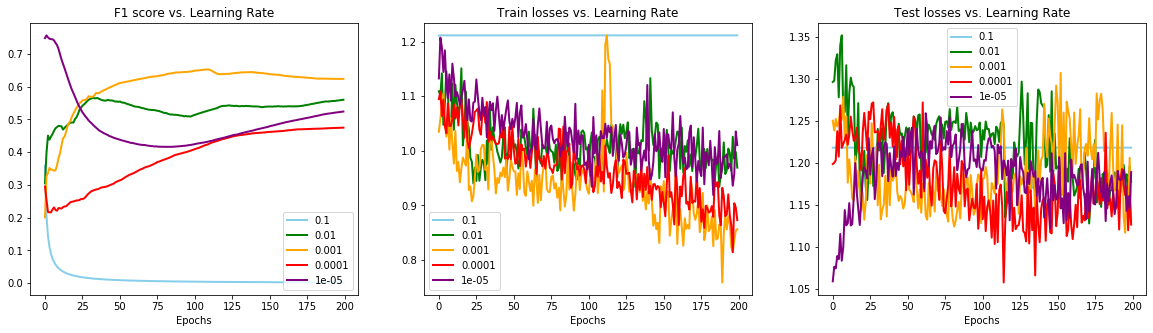

In [10]:
%run trainRNN_plot_utils.py
plot_inputs(F1_scores, trainLosses, testLosses, n_epoch, "Learning Rate")

In [11]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python friendly file
import pickle
with open('resultsStaticLearningRate_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )
    

Data saved into pickle.
